In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Dataset/BFDORIGINAL.zip"

Streaming output truncated to the last 5000 lines.
  inflating: BFDORIGINAL/train/not fractured/50-rotated3-rotated1-rotated3.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._50-rotated3-rotated1-rotated3.jpg  
  inflating: BFDORIGINAL/train/not fractured/68-rotated3-rotated3-rotated2.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._68-rotated3-rotated3-rotated2.jpg  
  inflating: BFDORIGINAL/train/not fractured/40-rotated3-rotated2.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._40-rotated3-rotated2.jpg  
  inflating: BFDORIGINAL/train/not fractured/34-rotated1-rotated2-rotated2.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._34-rotated1-rotated2-rotated2.jpg  
  inflating: BFDORIGINAL/train/not fractured/43-rotated2-rotated2-rotated2-rotated1.jpg  
  inflating: __MACOSX/BFDORIGINAL/train/not fractured/._43-rotated2-rotated2-rotated2-rotated1.jpg  
  inflating: BFDORIGINAL/train/not fractured/30-rotated3-rotated1.jpg  
  inflating:

In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import sklearn
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed

from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:
img = cv2.imread("/content/BFDORIGINAL/train/fractured/10-rotated1-rotated1-rotated1.jpg")
img.shape

(224, 224, 3)

In [ ]:
base_path = "/content/BFDORIGINAL"
IMAGE_SIZE = 224
BATCH_SIZE = 12
VERBOSE = 1

In [ ]:
class_names = ["fractured", "not fractured"]

In [ ]:
x_train=[]
y_train=[]

for i in class_names:
    count = 0
    folder_path = os.path.join(os.path.join(base_path,"train"), i)
    for j in tqdm(os.listdir(folder_path), ncols=70):
        if count == 1500:
          break
        count += 1
        img = cv2.imread(os.path.join(folder_path,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Train Dataset Loading complete')

for i in class_names:
    count = 0
    folder_path = os.path.join(os.path.join(base_path,"val"), i)
    for j in tqdm(os.listdir(folder_path), ncols=70):
        if count == 450:
          break
        count += 1
        img = cv2.imread(os.path.join(folder_path,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Test Dataset Loading complete')

x_train = np.array(x_train)
y_train = np.array(y_train)


x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

 10%|██▉                          | 450/4383 [00:00<00:04, 886.06it/s]


Train Dataset Loading complete


100%|██████████████████████████████| 240/240 [00:00<00:00, 917.06it/s]


Test Dataset Loading complete


['fractured' 'not fractured']
[810 690]


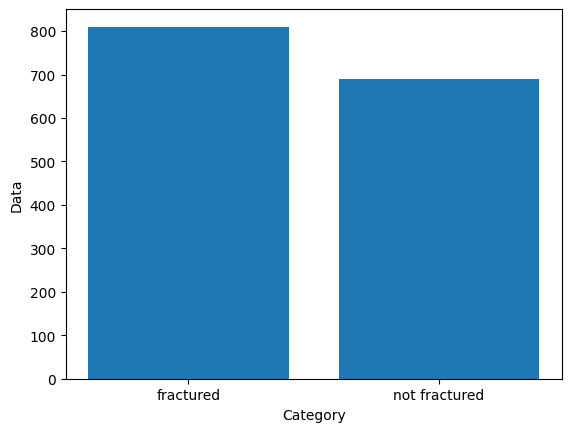

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)
plt.bar(unique,counts,align='center')
plt.xlabel('Category')
plt.ylabel('Data')
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=47, test_size=0.10)

print("Shapes X : Train :",x_train.shape,  " Test :",x_test.shape)
print("Shapes Y : Train :",y_train.shape,  " Test :",y_test.shape)

Shapes X : Train : (1350, 224, 224, 3)  Test : (150, 224, 224, 3)
Shapes Y : Train : (1350,)  Test : (150,)


In [ ]:
y_train_new = [class_names.index(i) for i in y_train]
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = [class_names.index(i) for i in y_test]
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
print(y_train[1])
print(y_train[2])

[0. 1.]
[1. 0.]


In [ ]:
print(np.argmax(y_train[1]))
print(np.argmax(y_train[2]))

1
0


In [ ]:
classes = np.unique(np.argmax(y_train, axis=1))
print(classes)

[0 1]


In [ ]:
mapping = dict(zip(classes, class_names))
mapping

{0: 'fractured', 1: 'not fractured'}

In [ ]:
inputShape = (IMAGE_SIZE, IMAGE_SIZE, 3)
model = Sequential()

In [ ]:
# Add Convolutional layers for feature extraction
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))

# Flatten the output before feeding it to LSTM
model.add(TimeDistributed(Flatten()))

# Add LSTM layer
model.add(LSTM(units=64))

model.add(Dense(units=len(classes), activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 111, 111, 64)      0         
 ng2D)                                                           
                                                                 
 time_distributed_11 (TimeD  (None, 111, 7104)         0         
 istributed)                                                     
                                                                 
 lstm_11 (LSTM)              (None, 64)                1835264   
                                                                 
 dense_11 (Dense)            (None, 2)                 130       
                                                                 
Total params: 1837186 (7.01 MB)
Trainable params: 183

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("lstm.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE,validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BATCH_SIZE,epochs=12, callbacks=[reduce_lr, checkpoint, tensorboard])

Epoch 1/12
110/112 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5515
Epoch 1: val_accuracy improved from -inf to 0.55333, saving model to lstm.h5
112/112 [==============================] - 9s 62ms/step - loss: 0.6945 - accuracy: 0.5484 - val_loss: 0.6622 - val_accuracy: 0.5533 - lr: 0.0010
Epoch 2/12
  4/112 [>.............................] - ETA: 2s - loss: 0.6266 - accuracy: 0.6667

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/112 [============================>.] - ETA: 0s - loss: 0.6778 - accuracy: 0.5282
Epoch 2: val_accuracy did not improve from 0.55333
112/112 [==============================] - 4s 35ms/step - loss: 0.6782 - accuracy: 0.5262 - val_loss: 0.6681 - val_accuracy: 0.5267 - lr: 0.0010
Epoch 3/12
110/112 [============================>.] - ETA: 0s - loss: 0.6688 - accuracy: 0.5700
Epoch 3: val_accuracy improved from 0.55333 to 0.56667, saving model to lstm.h5
112/112 [==============================] - 5s 46ms/step - loss: 0.6671 - accuracy: 0.5732 - val_loss: 0.6790 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 4/12
  4/112 [>.............................] - ETA: 1s - loss: 0.7139 - accuracy: 0.4524

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/112 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.5724
Epoch 4: val_accuracy improved from 0.56667 to 0.58667, saving model to lstm.h5
112/112 [==============================] - 5s 46ms/step - loss: 0.6698 - accuracy: 0.5732 - val_loss: 0.6695 - val_accuracy: 0.5867 - lr: 0.0010
Epoch 5/12
  4/112 [>.............................] - ETA: 1s - loss: 0.6567 - accuracy: 0.6429

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/112 [============================>.] - ETA: 0s - loss: 0.6709 - accuracy: 0.5528
Epoch 5: val_accuracy did not improve from 0.58667
112/112 [==============================] - 6s 57ms/step - loss: 0.6704 - accuracy: 0.5546 - val_loss: 0.6660 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/12
111/112 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.5641
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 6: val_accuracy did not improve from 0.58667
112/112 [==============================] - 3s 27ms/step - loss: 0.6655 - accuracy: 0.5658 - val_loss: 0.6622 - val_accuracy: 0.5200 - lr: 0.0010
Epoch 7/12
111/112 [============================>.] - ETA: 0s - loss: 0.6639 - accuracy: 0.5799
Epoch 7: val_accuracy did not improve from 0.58667
112/112 [==============================] - 3s 31ms/step - loss: 0.6638 - accuracy: 0.5785 - val_loss: 0.6628 - val_accuracy: 0.5600 - lr: 3.0000e-04
Epoch 8/12
111/112 [============================>.] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/112 [============================>.] - ETA: 0s - loss: 0.6625 - accuracy: 0.5935
Epoch 9: val_accuracy did not improve from 0.62667
112/112 [==============================] - 5s 46ms/step - loss: 0.6623 - accuracy: 0.5942 - val_loss: 0.6530 - val_accuracy: 0.5867 - lr: 3.0000e-04
Epoch 10/12
111/112 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.5618
Epoch 10: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.

Epoch 10: val_accuracy did not improve from 0.62667
112/112 [==============================] - 3s 27ms/step - loss: 0.6618 - accuracy: 0.5650 - val_loss: 0.6660 - val_accuracy: 0.6067 - lr: 3.0000e-04
Epoch 11/12
111/112 [============================>.] - ETA: 0s - loss: 0.6615 - accuracy: 0.5897
Epoch 11: val_accuracy did not improve from 0.62667
112/112 [==============================] - 3s 30ms/step - loss: 0.6609 - accuracy: 0.5904 - val_loss: 0.6621 - val_accuracy: 0.6267 - lr: 9.0000e-05
Epoch 12/12
112/112 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


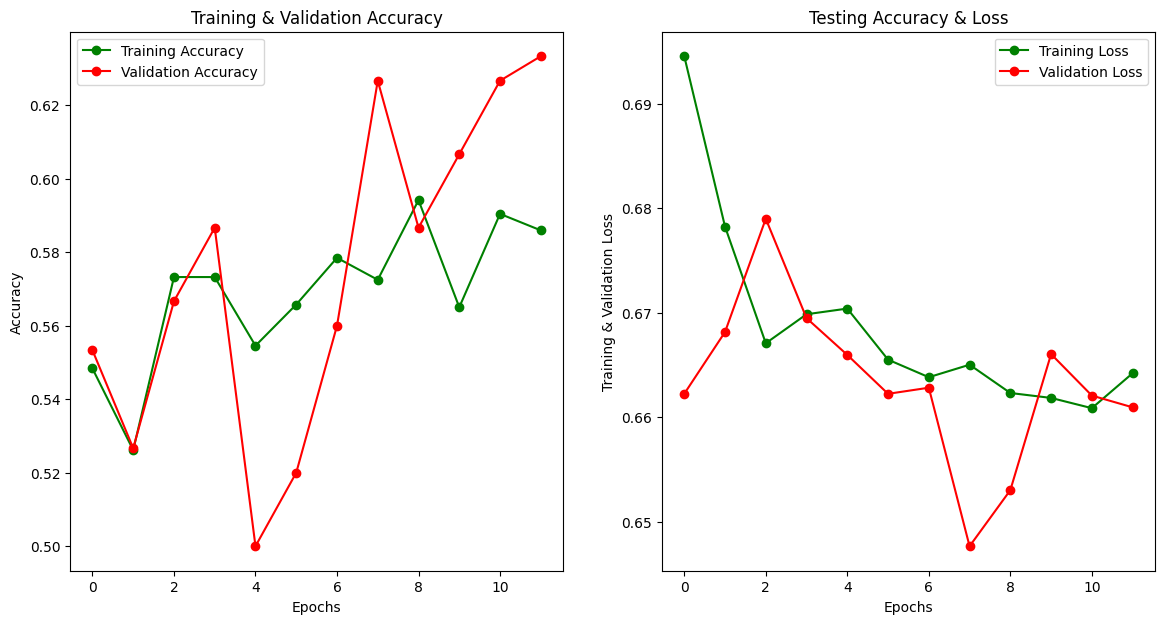

In [ ]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

In [ ]:
result = model.evaluate(x_test, y_test)
print("Testing Loss :", result[0])
print("Testing Accuracy :", result[1]*100, "%")

5/5 [==============================] - 1s 263ms/step - loss: 0.6609 - accuracy: 0.6333
Testing Loss : 0.6609398722648621
Testing Accuracy : 63.333332538604736 %


In [ ]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

5/5 [==============================] - 0s 18ms/step


In [ ]:
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions)
print(cf_report)

              precision    recall  f1-score   support

           0       0.75      0.51      0.60        83
           1       0.56      0.79      0.66        67

    accuracy                           0.63       150
   macro avg       0.66      0.65      0.63       150
weighted avg       0.67      0.63      0.63       150



<Axes: >

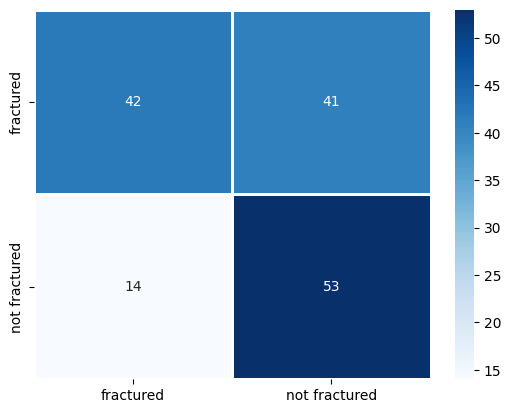

In [ ]:
import sklearn
import seaborn as sns
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=class_names, yticklabels=class_names)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.0 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
shap.initjs()

In [ ]:
masker = shap.maskers.Image("inpaint_telea", x_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_names)

explainer

In [ ]:
shap_values = explainer(x_test[0:1], outputs=shap.Explanation.argsort.flip[:5])

shap_values.shape

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.75s/it]               


(1, 224, 224, 3, 2)

In [ ]:
print("Actual Labels    : {}".format([mapping[i] for i in np.argmax(y_test[:1], axis=1)]))
probs = model.predict(x_test[:1])
print("Predicted Labels : {}".format([mapping[i] for i in np.argmax(probs, axis=1)]))
print("Probabilities : {}".format(np.max(probs, axis=1)))

Actual Labels    : ['not fractured']
1/1 [==============================] - 0s 85ms/step
Predicted Labels : ['not fractured']
Probabilities : [0.5059523]


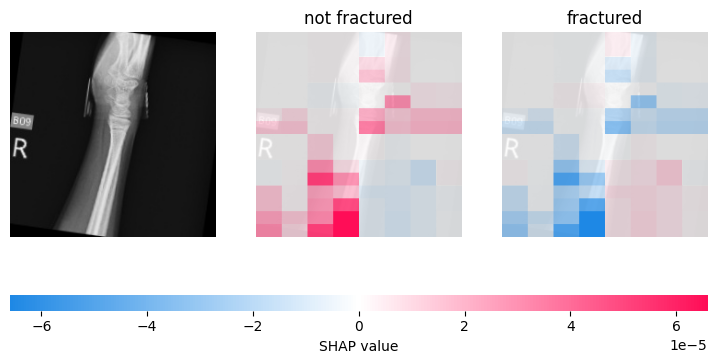

In [ ]:
shap.image_plot(shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.78s/it]               


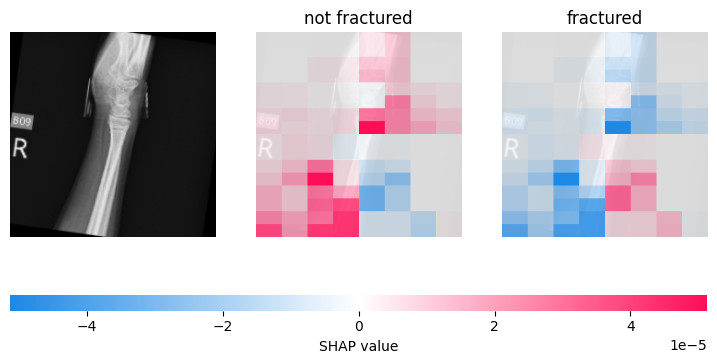

In [ ]:
masker = shap.maskers.Image("inpaint_ns", x_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_names)

shap_values = explainer(x_test[:1], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

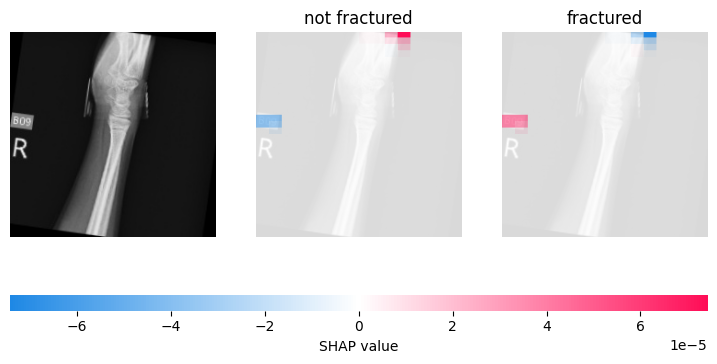

In [ ]:
masker = shap.maskers.Image("blur(28,28)", x_train[0].shape)

explainer = shap.Explainer(model, masker, output_names=class_names)

shap_values = explainer(x_test[:1], outputs=shap.Explanation.argsort.flip[:5])

shap.image_plot(shap_values)

In [ ]:
def input_img(image):
  image = tf.expand_dims(image, axis=0)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [224,224])
  return image

def normalize_image(img):
  grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
  grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)-
  tf.reduce_min(grads_norm))
  return grads_norm

def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
  f = plt.figure(figsize=(15,45))
  plt.subplot(1,3,1)
  plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="ocean")
  plt.axis("off")
  plt.subplot(1,3,2)
  plt.imshow(img2, cmap = "ocean")
  plt.axis("off")
  plt.subplot(1,3,3)
  plt.imshow(img1*mix_val+img2/mix_val, cmap = "ocean" )
  plt.axis("off")

In [ ]:
input_img = input_img(x_test[0]) # Hardcoded Test Image 0

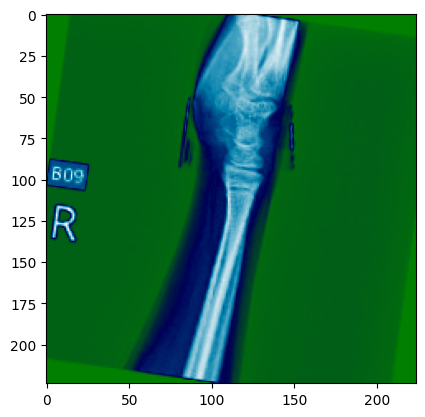

In [ ]:
plt.imshow(normalize_image(input_img[0]), cmap = "ocean")

In [ ]:
result = model(input_img)
max_idx = tf.argmax(result,axis = 1)

In [ ]:
result

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.49404773, 0.5059523 ]], dtype=float32)>

In [ ]:
max_idx

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>

In [ ]:
with tf.GradientTape() as tape:
  tape.watch(input_img)
  result = model(input_img)
  max_score = result[0,max_idx[0]]

In [ ]:
max_score

<tf.Tensor: shape=(), dtype=float32, numpy=0.5059523>

In [ ]:
grads = tape.gradient(max_score, input_img)

In [ ]:
grads

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dty

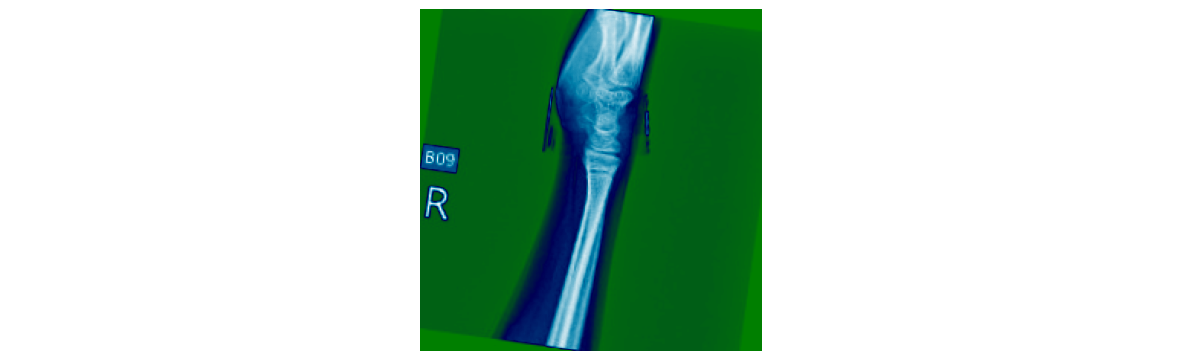

In [ ]:
plot_maps(normalize_image(grads[0]), normalize_image(input_img[0]))